In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [18]:
df = pd.read_csv('data/synthetic_malnutrition_12000.csv')
print(df.shape)
df.head()

(12000, 13)


,id,age_years,sex,height_cm,weight_kg,MUAC_cm,head_circumference_cm,birth_weight_kg,meals_per_day,household_income_inr,type_of_family,weight_for_age_z_like,label
0,1,1.77,Female,85.1,11.32,18.0,47.6,2.52,6,45964.36,Joint,-0.31,OK
1,2,1.24,Male,75.8,8.97,16.8,47.6,3.51,4,11867.24,Nuclear,-0.90,OK
2,3,2.08,Female,87.9,13.66,20.8,47.4,2.81,4,4362.64,Nuclear,0.46,OK
3,4,0.80,Female,72.6,9.88,18.0,42.2,2.83,7,27964.67,Nuclear,0.72,OK
4,5,2.75,Female,94.4,15.58,22.0,48.2,3.08,3,4813.53,Nuclear,0.45,OK


In [19]:
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Label encode categorical variables
for col in ['sex', 'type_of_family']:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Separate features and label
X = df.drop('label', axis=1)
y = df['label']
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
print(f'Train class distribution: {Counter(y_train)}')

# SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'SMOTE train class distribution: {Counter(y_train_smote)}')

# Feature scaling
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


Train class distribution: Counter({2: 8097, 0: 206, 1: 97})
SMOTE train class distribution: Counter({2: 8097, 0: 8097, 1: 8097})


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=8, class_weight='balanced',
    random_state=42)
rf_model.fit(X_train_smote_scaled, y_train_smote)


RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=42)

Random Forest Test Accuracy: 0.9413888888888889
              precision    recall  f1-score   support

  Borderline       0.25      0.61      0.36        88
Malnourished       0.68      0.68      0.68        41
          OK       0.99      0.95      0.97      3471

    accuracy                           0.94      3600
   macro avg       0.64      0.75      0.67      3600
weighted avg       0.97      0.94      0.95      3600



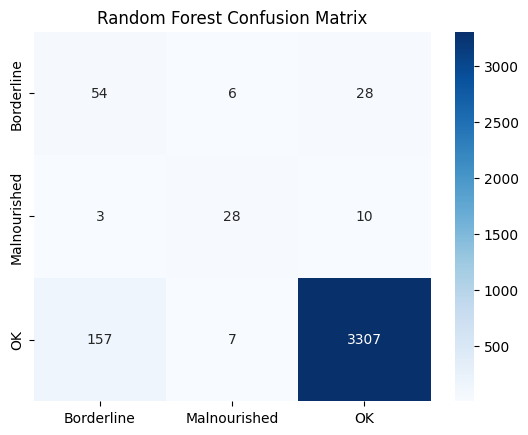

In [21]:
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)
print('Random Forest Test Accuracy:', accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=le_target.classes_))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [22]:
# Accuracy, Precision, Recall and F1-Score 
accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, average='weighted')
recall = recall_score(y_test, rf_pred, average='weighted')
f1 = f1_score(y_test, rf_pred, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.9414
Precision: 0.9672
Recall: 0.9414
F1-Score: 0.9521


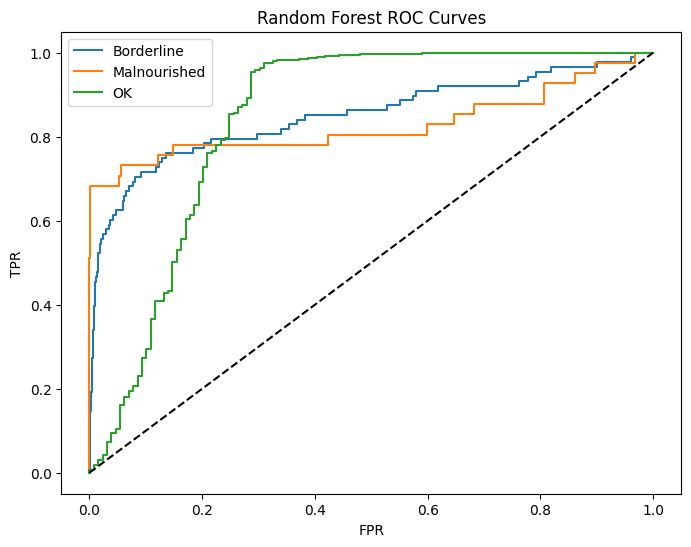

In [23]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(8,6))
for i, label in enumerate(le_target.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], rf_proba[:,i])
    plt.plot(fpr, tpr, label=f'{label}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest ROC Curves')
plt.legend()
plt.show()


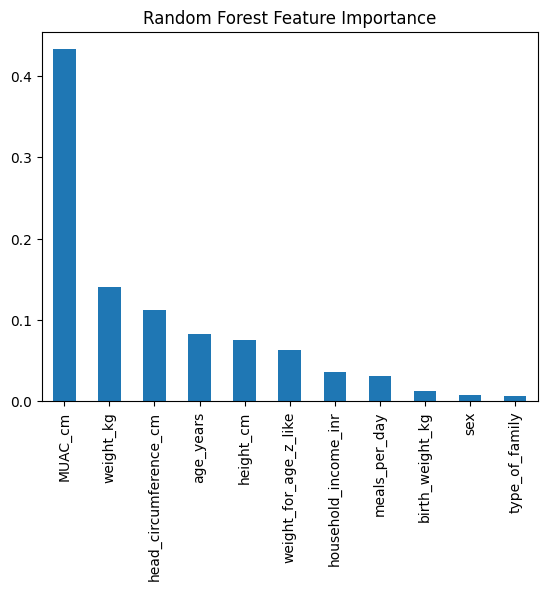

In [24]:
fi = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
fi.plot(kind='bar', title='Random Forest Feature Importance')
plt.show()


In [25]:
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [26]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.1,
    objective='multi:softprob', eval_metric='mlogloss',
    random_state=42, use_label_encoder=False)
xgb_model.fit(X_train_smote_scaled, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

XGBoost Test Accuracy: 0.9627777777777777
              precision    recall  f1-score   support

  Borderline       0.44      0.58      0.50        88
Malnourished       0.49      0.66      0.56        41
          OK       0.99      0.98      0.98      3471

    accuracy                           0.96      3600
   macro avg       0.64      0.74      0.68      3600
weighted avg       0.97      0.96      0.97      3600



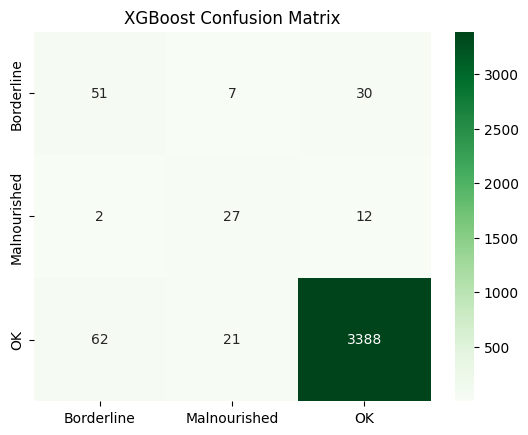

In [27]:
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)
print('XGBoost Test Accuracy:', accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, target_names=le_target.classes_))
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('XGBoost Confusion Matrix')
plt.show()


In [28]:
# accuracy, Precision, Recall and F1-Score 
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred, average='weighted')
recall = recall_score(y_test, xgb_pred, average='weighted')
f1 = f1_score(y_test, xgb_pred, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.9628
Precision: 0.9688
Recall: 0.9628
F1-Score: 0.9654


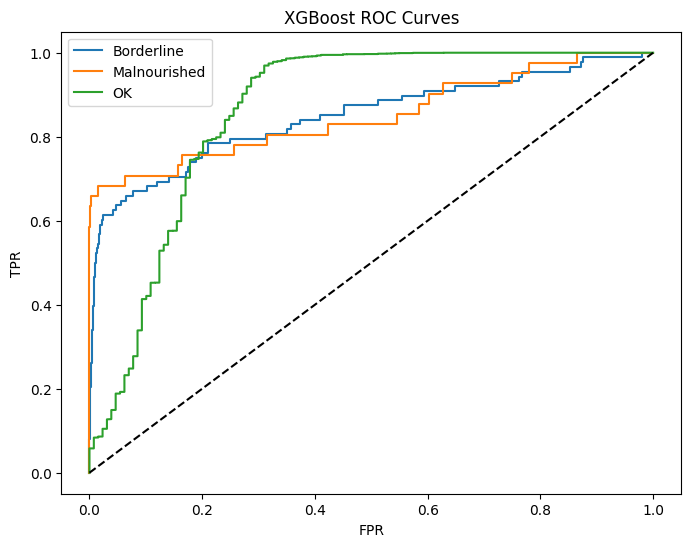

In [29]:
plt.figure(figsize=(8,6))
for i, label in enumerate(le_target.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], xgb_proba[:,i])
    plt.plot(fpr, tpr, label=f'{label}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('XGBoost ROC Curves')
plt.legend()
plt.show()


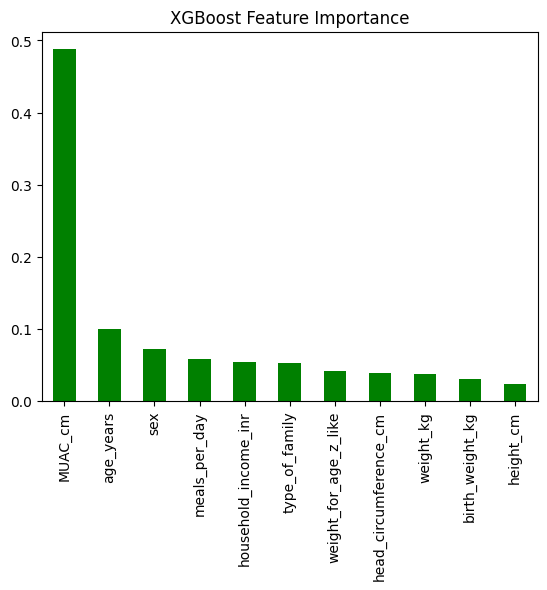

In [30]:
fi_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
fi_xgb.plot(kind='bar', color='green', title='XGBoost Feature Importance')
plt.show()


In [31]:
joblib.dump(xgb_model, 'xgboost_model.pkl')


['xgboost_model.pkl']